# MEME CLASSIFIER - TASK 3

Useful links:
- [TRANSFORMERS DOCS](https://huggingface.co/docs/transformers)
- [TASK PAGE](https://propaganda.math.unipd.it/semeval2021task6/)
- [TASK GITHUB](https://github.com/di-dimitrov/SEMEVAL-2021-task6-corpus#task-description)
- [SIMULA IMAGE SENTIMENT DATASET](https://datasets.simula.no/image-sentiment/)
- [IMAGE SENTIMENT POLARITY DATASET](https://data.world/crowdflower/image-sentiment-polarity)
- [VISUAL SENTIMENT ANALYSIS FOR REVIEW IMAGES PAPER](https://drive.google.com/file/d/1ZGfGTExiqFN4Uh8uH9lJuksPF-lUJH9B/edit)
- [VS-CNN GITHUB](https://github.com/PreferredAI/vs-cnn/blob/master/model_base.py)
- [RA-DLNet PAPER](https://link.springer.com/article/10.1007/s00530-020-00656-7)
- [SURVEY ON VISUAL SENTIMENT ANALYSIS](https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/iet-ipr.2019.1270)
- [SIMPLE IMAGE SENTIMENT ANALYSIS GITHUB](https://github.com/graju1401/Image-Sentiment-Analysis/blob/master/image_analysis.py)

### PACKAGES INSTALLATION


In [3]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### DRIVE LINKING

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### CONSTANTS

In [5]:
LABELS = {
    'Black-and-white Fallacy/Dictatorship': 0,
    'Loaded Language': 1, 
    'Name calling/Labeling': 2, 
    'Slogans': 3, 
    'Smears': 4, 
    'Causal Oversimplification': 5, 
    'Appeal to fear/prejudice': 6, 
    'Exaggeration/Minimisation': 7, 
    'Reductio ad hitlerum': 8, 
    'Repetition': 9, 
    'Glittering generalities (Virtue)': 10, 
    "Misrepresentation of Someone's Position (Straw Man)": 11, 
    'Doubt': 12, 
    'Obfuscation, Intentional vagueness, Confusion': 13, 
    'Whataboutism': 14, 
    'Flag-waving': 15, 
    'Thought-terminating cliché': 16, 
    'Presenting Irrelevant Data (Red Herring)': 17, 
    'Appeal to authority': 18, 
    'Bandwagon': 19,
    'Transfer' : 20,
    'Appeal to (Strong) Emotions' : 21
}

N_LABELS = len(LABELS)

### IMPORTS

In [6]:
import os
from datetime import datetime

import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tabulate import tabulate
import seaborn as sn

from tqdm.notebook import tqdm

from torch.utils.data import DataLoader

from PIL import Image

import torch 
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
import torch.nn as nn

from transformers import AutoTokenizer
from transformers import AutoModel, AutoConfig
from transformers import PreTrainedModel, BertModel, BertConfig
from transformers import AutoFeatureExtractor, ResNetForImageClassification
from transformers import get_linear_schedule_with_warmup
from transformers.utils import logging

from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve

### DATASET

####  DATASET LOADING

In [7]:
def process_image(img):

    img = img.resize((240, 240))
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.reshape(img, (3, 240, 240))

    return img

def load_datasets():

    def load(data_dir): 

        txt_fname = [f for f in os.listdir(data_dir) if f.endswith('.txt')][0]
        
        with open(data_dir + txt_fname) as f:
            data = json.load(f)

        data = pd.DataFrame(data)
        
        imgs = []
        for img_fname in data.image:
            if os.path.exists(data_dir + img_fname):
                img = Image.open(data_dir + img_fname).convert("RGB")
                img = process_image(img)
                imgs.append(img)
            else:
                data.drop(data.index[data['id']==id], inplace=True)

        img_df = pd.DataFrame({'img': imgs})

        return pd.concat([data, img_df], axis=1)

    folder = "drive/MyDrive/DeepLearning/Dataset/task3/"

    train = load(folder + "training/")
    test = load(folder + "test/")
    dev = load(folder + "dev/")

    return train , test, dev

#### LABELS ENCODING

In [8]:
def one_hot_encoder(df):

    def encode(labels):

        ohe_label = [0] * N_LABELS
        for l in labels:
            ohe_label[LABELS[l]] = 1

        return ohe_label

    return pd.DataFrame([encode(labels) for labels in df["labels"]])

#### DATASET

In [9]:
class MemeDataset():


    def __init__(self, texts, labels, imgs, tokenizer):

        self.texts = texts
        self.labels = labels
        
        self.tokenizer = tokenizer

        self.imgs = imgs
    
    def __len__(self):

        return len(self.texts)

    def __getitem__(self, index):

        text = self.texts[index]
        label = self.labels[index]
        img = self.imgs[index]

        inputs = self.tokenizer.__call__(text,
                                         None,
                                         add_special_tokens=True,
                                         padding="max_length",
                                         truncation=True,
                                         )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "img": torch.tensor(img, dtype=torch.float),
            "labels": torch.tensor(label, dtype=torch.long)
        }

#### WRAPPERS

In [10]:
def process_datasets(train, test, dev):

    def process_dataset(df):

        ohe_labels = one_hot_encoder(df)
        return pd.concat([df, ohe_labels], axis=1)

    train_ps = process_dataset(train)
    test_ps = process_dataset(test)
    dev_ps = process_dataset(dev)

    return train_ps, test_ps, dev_ps

def build_datasets(train, test, dev):

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def get_labels(df): return df[range(N_LABELS)].values.tolist()

    train_ds = MemeDataset(
        train.text.tolist(), get_labels(train), train.img, tokenizer)
    test_ds = MemeDataset(
        test.text.tolist(), get_labels(test), test.img, tokenizer)
    dev_ds = MemeDataset(
        dev.text.tolist(), get_labels(dev), dev.img, tokenizer)
    
    return train_ds, test_ds, dev_ds

def build_dataloaders(train_ds, test_ds, dev_ds):
    
    train_dl = DataLoader(train_ds, batch_size=6, shuffle=True, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=6, shuffle=True, num_workers=2)
    dev_dl = DataLoader(dev_ds, batch_size=6, shuffle=True, num_workers=2)

    return train_dl, test_dl, dev_dl 

### MODEL

In [11]:
class MemeClassifier(nn.Module):
    """Our classifier for Task 3.
    
    It predicts a label for every class based on the concatenation 
    of the features given by a Bert transformer and a ResNet, which 
    are then fed to a linear layer."""

    def __init__(self, n_classes, do_prob=0.2, bert_path="bert-base-uncased"):

        super(MemeClassifier, self).__init__()

        self.resnet = ResNetForImageClassification.from_pretrained(
            "microsoft/resnet-50")
        self.img_fc = nn.Linear(1000, 100)
        
        self.bert = BertModel.from_pretrained(bert_path)
        self.step_scheduler_after = "batch"
        self.dropout = nn.Dropout(do_prob)

        self.linear = nn.Linear(868, n_classes)
        self.sigmoid = torch.sigmoid

    def forward(self, input_ids, img, attention_mask=None):

        output = self.bert(
            input_ids, attention_mask=attention_mask)["pooler_output"]
        output = self.dropout(output)

        img = self.resnet(img)
        img = self.img_fc(img.logits)

        output = torch.cat((output, img), dim=1)
        output = self.linear(output)
        output = self.sigmoid(output)

        return output
    
    def load_resnet(self, path, device):

        config = torch.load(path, map_location=device)['model_state_dict']
        config.pop('module.linear.weight', None)
        config.pop('module.linear.bias', None)

        classifier_config = dict()
        classifier_config.update(
            {'weight': config.pop('module.classifier.weight')})
        classifier_config.update(
            {'bias': config.pop('module.classifier.bias')})
        
        new_config = config.copy()
        for key in config:
            new_key = key[14:]
            new_config[new_key] = new_config.pop(key)

        self.resnet.load_state_dict(new_config)
        self.img_fc.load_state_dict(classifier_config)

In [12]:
class MemeClassifierWeighted(nn.Module):
    """Our classifier for Task 3.
    
    It predicts a label for every class based on the weighted average 
    given by a Bert transformer and a ResNet."""

    def __init__(self, n_classes, do_prob=0.2, bert_path="bert-base-uncased"):

        super(MemeClassifierWeighted, self).__init__()

        self.resnet = ResNetForImageClassification.from_pretrained(
            "microsoft/resnet-50")
        self.img_fc = nn.Linear(1000, 100)
        self.img_fc2 = nn.Linear(100, n_classes)
        
        self.bert = BertModel.from_pretrained(bert_path)
        self.step_scheduler_after = "batch"
        self.dropout = nn.Dropout(do_prob)
        self.text_fc = nn.Linear(768, n_classes)

        self.weights = nn.Parameter(torch.ones(n_classes) / 2)

        self.sigmoid = torch.sigmoid

    def forward(self, input_ids, img, attention_mask=None):

        t_output = self.bert(
            input_ids, attention_mask=attention_mask)["pooler_output"]
        t_output = self.dropout(t_output)
        t_output = self.text_fc(t_output)
        t_output = self.sigmoid(t_output)

        i_output = self.resnet(img)
        i_output = self.img_fc(i_output.logits)
        i_output = self.img_fc2(i_output)
        i_output = self.sigmoid(i_output)

        output = t_output*self.weights + i_output*(1-self.weights)

        return output
    
    def load_resnet(self, path, device):

        config = torch.load(path, map_location=device)['model_state_dict']

        # removes last layer
        config.pop('module.linear.weight', None)
        config.pop('module.linear.bias', None)

        # extraction of linear layer configuration
        classifier_config = dict()
        classifier_config.update(
            {'weight': config.pop('module.classifier.weight')})
        classifier_config.update(
            {'bias': config.pop('module.classifier.bias')})
        
        # change of names in resnet config for compatibility
        new_config = config.copy()
        for key in config:
            new_key = key[14:]
            new_config[new_key] = new_config.pop(key)

        self.resnet.load_state_dict(new_config)
        self.img_fc.load_state_dict(classifier_config)

In [13]:
def save_model(model, thresholds, path):
    """Saves the models with their thresholds."""

    torch.save({
            'model_state_dict': model.state_dict(),
            'thresholds': thresholds,
            }, path)

def load_model(path, device, use_weighted=False):
    """Loads the models saved with their thresholds."""

    if use_weighted:
        model = MemeClassifierWeighted(N_LABELS)
    else:
        model = MemeClassifier(N_LABELS)

    model = nn.DataParallel(model)

    checkpoint = torch.load(path, device)

    model.load_state_dict(checkpoint['model_state_dict'])
    thresholds = checkpoint['thresholds']
    
    return model, thresholds

### OPTIMIZER

In [14]:
def build_optimizer(model, lr=3e-5):

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(
                    nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(
                    nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    opt = AdamW(optimizer_parameters, lr=lr)
    return opt

### PLOTTER

In [15]:
class Plotter():
    """Keeps track of the metrics and create plots."""

    def __init__(self):

        self.data = {}

    def add(self, d):

        for metric in d:
            if metric in self.data: 
                self.data[metric].append(d[metric])
            else: 
                self.data[metric] = [d[metric]]

    def plot_metric(self, metric):

        y = self.data[metric]
        x = range(1, len(y) + 1)

        plt.figure()
        plt.title(metric)
        plt.xlabel('epoch')
        plt.plot(x, y) 

    def plot(self):

        for metric in self.data:
            self.plot_metric(metric)
            plt.show()

    def save(self, dir_name):

        if not os.path.isdir(dir_name): return
            
        for metric in self.data:
            self.plot_metric(metric)

            plt.savefig("".join([dir_name, metric]))
            plt.close()

### TRAINER

In [16]:
class FocalLoss(nn.modules.loss._WeightedLoss):


    def __init__(self, weight=None, gamma=2):

        super(FocalLoss, self).__init__(weight)
        self.gamma = gamma
        self.weight = weight 

    def forward(self, input, target):

        ce_loss =  F.binary_cross_entropy(
            input, target, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

In [17]:
def find_opt_threshold(outputs, labels):

    def to_labels(outputs, threshold): 
        return (outputs >= threshold).astype('int')

    thresholds = np.arange(0.1, 1, 0.001)

    scores = [
        f1_score(
            labels, 
            to_labels(outputs, t), 
            average=None, 
            zero_division=1
        ) for t in thresholds
    ]

    idxs = np.argmax(scores, axis=0)

    return np.take(thresholds, idxs)

def find_opt_threshold_gmean(outputs, labels):

    def get_t(lab, out):

        fpr, tpr, thresholds = roc_curve(lab, out)
        gmeans = np.sqrt(tpr * (1-fpr))
        return thresholds[np.argmax(gmeans)]

    return np.array(
        [get_t(lab, out) for lab, out in zip(labels.T, outputs.T)])

def apply_threshold_per_class(outputs, thresholds):

    y = []

    for output in outputs: 
        y.append([0 if p < t else 1 for p, t in zip(output, thresholds)])

    return np.array(y)

def apply_threshold_to_all(outputs, threshold):

    return (outputs >= threshold).astype('int')

def get_metrics(preds, labels):    

    f1_micro = f1_score(labels, preds, average='micro', zero_division=1)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=1)

    return {'f1-micro': f1_micro, 'f1-macro': f1_macro}

In [18]:
def eval(dataloader, model, device, loss_fn=None, thresholds=None):

    eval_loss = 0.0
    model.eval()

    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in enumerate(dataloader):
            ids = d["ids"]
            mask = d["mask"]
            targets = d["labels"]
            img = d["img"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            img = img.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(ids, img=img, attention_mask=mask)

            if loss_fn is not None:
                loss = loss_fn(outputs, targets)
                eval_loss += loss.item()

            fin_targets.extend(targets)
            fin_outputs.extend(outputs)

    fin_outputs = torch.stack(fin_outputs)
    fin_targets = torch.stack(fin_targets)
    fin_outputs = fin_outputs.cpu().detach().numpy()
    fin_targets = fin_targets.cpu().detach().numpy()

    if thresholds is None:
        thresholds = find_opt_threshold(fin_outputs, fin_targets)
    
    pred = apply_threshold_per_class(fin_outputs, thresholds)
    pred_non_opt = apply_threshold_to_all(fin_outputs, 0.5)
        
    return {
        "loss": eval_loss,
        "output": fin_outputs,
        "pred": pred,
        "pred_non_opt": pred_non_opt,
        "true": fin_targets,
        "thresholds": thresholds,
    }


class Trainer():
    """Trains a model while printing results."""

    def __init__(self, model, optimizer, scheduler, device, loss_fn):

        self.net = model
        self.opt = optimizer 
        self.scheduler = scheduler
        self.device = device
        self.loss_fn = loss_fn
        self.plotter = Plotter()

    def eval(self, dataloader, thresholds):

        return eval(dataloader, 
                    self.net, 
                    self.device, 
                    loss_fn=self.loss_fn,
                    thresholds=thresholds)

    def train(self, train_dl, val_dl, epochs, save_dir=None, dir_name=None):

        def train_fn():

            train_loss = 0.0
            self.net.train()

            fin_outputs = []
            fin_targets = []
            for bi, d in tqdm(enumerate(train_dl), total=len(train_dl)):
                ids = d["ids"]
                mask = d["mask"]
                targets = d["labels"]
                img = d["img"]

                ids = ids.to(self.device, dtype=torch.long)
                mask = mask.to(self.device, dtype=torch.long)
                img = img.to(self.device, dtype=torch.float)
                targets = targets.to(self.device, dtype=torch.float)

                outputs = self.net(ids, img=img, attention_mask=mask)
                self.opt.zero_grad()

                loss = loss_fn(outputs, targets)
                loss.backward()
                train_loss += loss.item()
                self.opt.step()
                self.scheduler.step()

                fin_targets.extend(targets)
                fin_outputs.extend(outputs)

            fin_outputs = torch.stack(fin_outputs)
            fin_targets = torch.stack(fin_targets)
            fin_outputs = fin_outputs.cpu().detach().numpy()
            fin_targets = fin_targets.cpu().detach().numpy() 

            thresholds = find_opt_threshold(fin_outputs, fin_targets)
                
            return train_loss, thresholds
        
        if save_dir is not None and os.path.isdir(save_dir):
            datestring = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            if dir_name is None:  
                save_dir = "".join([save_dir, datestring, "/"])
            elif os.path.isdir("".join([save_dir, dir_name, "/"])):
                save_dir = "".join([save_dir, dir_name, datestring, "/"])
                print(
                    "dir_name specicified already exists. Saving as {}".format(
                        save_dir))
            else:
                save_dir = "".join([save_dir, dir_name, "/"])

            os.mkdir(save_dir)

        best_val_loss = 100
        best_val_micro = 0
        best_val_micro_no = 0

        for epoch in tqdm(range(epochs)):
            train_loss, thresholds = train_fn()
            res = self.eval(val_dl, thresholds)

            eval_loss = res['loss']
            pred = res['pred']
            pred_non_opt = res['pred_non_opt']
            true = res['true']

            avg_train_loss = train_loss / len(train_dl)
            avg_val_loss = eval_loss / len(val_dl)
            
            metrics = get_metrics(pred, true)
            metrics_non_opt = get_metrics(pred_non_opt, true)

            metrics['train_loss'] = avg_train_loss
            metrics['val_loss'] = avg_val_loss
            metrics['f1-micro_non_opt'] = metrics_non_opt['f1-micro']
            metrics['f1-macro_non_opt'] = metrics_non_opt['f1-macro']

            self.plotter.add(metrics)

            print("Epoch {}:".format(epoch))
            print("Average Train loss: ", avg_train_loss)
            print("Average Valid loss: ", avg_val_loss)
            print("F1-micro: ", metrics['f1-micro'])
            print("F1-macro: ", metrics['f1-macro'])

            if save_dir is not None:
                save_msg = "Model saved as current {} is: {:.4f}"
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    save_model(
                        self.net, thresholds, save_dir + "best_model_loss.pt")
                    print(save_msg.format("val_loss", best_val_loss))

                if metrics['f1-micro'] > best_val_micro:
                    best_val_micro = metrics['f1-micro']
                    save_model(
                        self.net, thresholds, save_dir + "best_model_micro.pt")
                    print(save_msg.format("micro", best_val_micro))

                if metrics['f1-micro_non_opt'] > best_val_micro_no:
                    best_val_micro_no = metrics['f1-micro_non_opt']
                    save_model(
                        self.net, 
                        thresholds, 
                        save_dir + "best_model_micro_non_opt.pt")
                    print(save_msg.format("micro_non_opt", best_val_micro_no))

                self.plotter.save(save_dir) 

    def plot_metrics(self):

        self.plotter.plot()

### TRAINING

In [19]:
def get_alpha(data):

    labels = torch.tensor(one_hot_encoder(data).values.tolist())

    n_per_class = torch.sum(labels, dim=0)

    return max(n_per_class) / n_per_class

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(128)

In [21]:
train, test, dev = load_datasets()

In [22]:
train, test, dev = process_datasets(train, test, dev)

In [23]:
train_ds, test_ds, dev_ds = build_datasets(train, test, dev)
train_dl, test_dl, dev_dl = build_dataloaders(train_ds, test_ds, dev_ds)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
bert_unfrozen = "drive/MyDrive/DeepLearning/Models/\
Pretrained_unfrozen/checkpoint-40000"
bert_frozen = "drive/MyDrive/DeepLearning/Models/\
Pretrained_frozen/checkpoint-40000"

model = MemeClassifierWeighted(N_LABELS, bert_path=bert_frozen)
model.load_resnet("/content/drive/MyDrive/DeepLearning/Models\
/resnet-50/best_model_loss.pt", device)

# alpha = get_alpha(train_dl).to(device)
# loss_fn = FocalLoss()
loss_fn = nn.BCELoss()

model.to(device)
model = nn.DataParallel(model)

Downloading:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/103M [00:00<?, ?B/s]

Some weights of the model checkpoint at drive/MyDrive/DeepLearning/Models/Pretrained_frozen/checkpoint-40000 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at drive/MyDrive/DeepLearning/Models/Pretrained_frozen/chec

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 0:
Average Train loss:  0.3322382298500641
Average Valid loss:  0.2853673466227271
F1-micro:  0.4583333333333333
F1-macro:  0.26789494075317566
Model saved as current val_loss is: 0.2854
Model saved as current micro is: 0.4583
Model saved as current micro_non_opt is: 0.5113


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 1:
Average Train loss:  0.2536454897859822
Average Valid loss:  0.2673680254004218
F1-micro:  0.4444444444444444
F1-macro:  0.3161706723408329
Model saved as current val_loss is: 0.2674


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2:
Average Train loss:  0.2302934758041216
Average Valid loss:  0.2577427192167802
F1-micro:  0.5558086560364465
F1-macro:  0.3711938909666182
Model saved as current val_loss is: 0.2577
Model saved as current micro is: 0.5558
Model saved as current micro_non_opt is: 0.5304


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3:
Average Train loss:  0.19834605468356092
Average Valid loss:  0.25326868485320697
F1-micro:  0.5824175824175825
F1-macro:  0.30682986381472027
Model saved as current val_loss is: 0.2533
Model saved as current micro is: 0.5824
Model saved as current micro_non_opt is: 0.6000


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4:
Average Train loss:  0.1717094595665517
Average Valid loss:  0.25731719352982263
F1-micro:  0.5657894736842106
F1-macro:  0.33536805970384714


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5:
Average Train loss:  0.15067382254030393
Average Valid loss:  0.26665536246516486
F1-micro:  0.5864197530864197
F1-macro:  0.35400085080936144
Model saved as current micro is: 0.5864


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6:
Average Train loss:  0.13444432661585184
Average Valid loss:  0.26653201471675525
F1-micro:  0.5882352941176471
F1-macro:  0.36664911664911665
Model saved as current micro is: 0.5882


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7:
Average Train loss:  0.12242918464800585
Average Valid loss:  0.2822006642818451
F1-micro:  0.5975609756097561
F1-macro:  0.3732040155485132
Model saved as current micro is: 0.5976


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8:
Average Train loss:  0.11166791945048
Average Valid loss:  0.28654687106609344
F1-micro:  0.6179401993355482
F1-macro:  0.3385632825955407
Model saved as current micro is: 0.6179


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9:
Average Train loss:  0.10409805962572927
Average Valid loss:  0.28930114209651947
F1-micro:  0.59672131147541
F1-macro:  0.3488409051604417


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10:
Average Train loss:  0.09824778849016065
Average Valid loss:  0.30566352063959296
F1-micro:  0.6258064516129033
F1-macro:  0.3860496784890449
Model saved as current micro is: 0.6258


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 11:
Average Train loss:  0.0934977980411571
Average Valid loss:  0.30937601219524036
F1-micro:  0.6116207951070337
F1-macro:  0.37200810089493325


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 12:
Average Train loss:  0.08930517778448437
Average Valid loss:  0.3121384957974607
F1-micro:  0.6019417475728156
F1-macro:  0.3650599997288186


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 13:
Average Train loss:  0.08618379212591959
Average Valid loss:  0.3216723176566037
F1-micro:  0.6084142394822006
F1-macro:  0.37490686915820604


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 14:
Average Train loss:  0.08384116855652436
Average Valid loss:  0.3104998455806212
F1-micro:  0.5969230769230769
F1-macro:  0.37876983722068386


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 15:
Average Train loss:  0.08097042838192504
Average Valid loss:  0.32729343663562427
F1-micro:  0.6062500000000001
F1-macro:  0.3737241300424048


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 16:
Average Train loss:  0.07889118962313818
Average Valid loss:  0.3328188522295518
F1-micro:  0.6158536585365854
F1-macro:  0.3757650170902235


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 17:
Average Train loss:  0.07653852618582871
Average Valid loss:  0.330138316208666
F1-micro:  0.6042296072507554
F1-macro:  0.3794967385876477


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 18:
Average Train loss:  0.07539027304105136
Average Valid loss:  0.34655540775169025
F1-micro:  0.6238532110091743
F1-macro:  0.3727130608025757


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 19:
Average Train loss:  0.07431941437332526
Average Valid loss:  0.3345907845280387
F1-micro:  0.622754491017964
F1-macro:  0.37420555983605835
Model saved as current micro_non_opt is: 0.6027


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 20:
Average Train loss:  0.07271355610826741
Average Valid loss:  0.36321501298384234
F1-micro:  0.6194690265486725
F1-macro:  0.37669686253002244


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 21:
Average Train loss:  0.07167755864236666
Average Valid loss:  0.3570425727150657
F1-micro:  0.6060606060606061
F1-macro:  0.3741996954529752


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 22:
Average Train loss:  0.07074054094112438
Average Valid loss:  0.35003324259411206
F1-micro:  0.6135693215339232
F1-macro:  0.3805691650189258


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 23:
Average Train loss:  0.06956452404999215
Average Valid loss:  0.3528080216862939
F1-micro:  0.6117647058823529
F1-macro:  0.3720075246391035


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 24:
Average Train loss:  0.0686071231637312
Average Valid loss:  0.3796906105496667
F1-micro:  0.6153846153846153
F1-macro:  0.3646463429946938


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 25:
Average Train loss:  0.0675260228631289
Average Valid loss:  0.3328302638097243
F1-micro:  0.6231454005934718
F1-macro:  0.3814339403911596
Model saved as current micro_non_opt is: 0.6090


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 26:
Average Train loss:  0.0670572905436806
Average Valid loss:  0.36667417125268414
F1-micro:  0.6318840579710145
F1-macro:  0.3833859336169555
Model saved as current micro is: 0.6319
Model saved as current micro_non_opt is: 0.6267


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 27:
Average Train loss:  0.06676033723937429
Average Valid loss:  0.36513145674358716
F1-micro:  0.6140350877192982
F1-macro:  0.36754936917643993


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 28:
Average Train loss:  0.06618102926598943
Average Valid loss:  0.370741295543584
F1-micro:  0.6112759643916913
F1-macro:  0.37631977870614236


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 29:
Average Train loss:  0.06578512635567914
Average Valid loss:  0.3998393727974458
F1-micro:  0.619047619047619
F1-macro:  0.3693903606065115


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 30:
Average Train loss:  0.06481228018908397
Average Valid loss:  0.39308389208533545
F1-micro:  0.608955223880597
F1-macro:  0.3639033398914822


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 31:
Average Train loss:  0.06384243707617988
Average Valid loss:  0.3648002513430335
F1-micro:  0.6290801186943619
F1-macro:  0.37990218162905


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 32:
Average Train loss:  0.06359457681360452
Average Valid loss:  0.3574907671321522
F1-micro:  0.6163141993957703
F1-macro:  0.378420986128496


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 33:
Average Train loss:  0.06229212596688582
Average Valid loss:  0.3603206547823819
F1-micro:  0.6094674556213018
F1-macro:  0.3914405308685186


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 34:
Average Train loss:  0.061196715222752614
Average Valid loss:  0.37633752687410876
F1-micro:  0.608955223880597
F1-macro:  0.3781064282753874


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 35:
Average Train loss:  0.06152702829112177
Average Valid loss:  0.3771760395982049
F1-micro:  0.6369047619047619
F1-macro:  0.38181125095000695
Model saved as current micro is: 0.6369
Model saved as current micro_non_opt is: 0.6284


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 36:
Average Train loss:  0.06014423922676107
Average Valid loss:  0.3745530884374272
F1-micro:  0.625
F1-macro:  0.3961115247676512


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 37:
Average Train loss:  0.06016759490189345
Average Valid loss:  0.38074707849459216
F1-micro:  0.6213017751479291
F1-macro:  0.3747732900235318


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 38:
Average Train loss:  0.05960495530263237
Average Valid loss:  0.3807570961388675
F1-micro:  0.626865671641791
F1-macro:  0.37104874292374296


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 39:
Average Train loss:  0.059180775948840636
Average Valid loss:  0.3860679702325301
F1-micro:  0.6084337349397589
F1-macro:  0.36181956508043467


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 40:
Average Train loss:  0.05906069071396537
Average Valid loss:  0.37677923522212287
F1-micro:  0.6208955223880596
F1-macro:  0.3592068078910185


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 41:
Average Train loss:  0.05899310746918554
Average Valid loss:  0.3806200311942534
F1-micro:  0.6163141993957703
F1-macro:  0.3589835665624826


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 42:
Average Train loss:  0.058507472341475276
Average Valid loss:  0.38107785853472625
F1-micro:  0.6172106824925816
F1-macro:  0.35838036161002673


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 43:
Average Train loss:  0.05807636937369471
Average Valid loss:  0.37825188718058844
F1-micro:  0.631578947368421
F1-macro:  0.383158613661006
Model saved as current micro_non_opt is: 0.6291


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 44:
Average Train loss:  0.05761093474600626
Average Valid loss:  0.392824225127697
F1-micro:  0.6231454005934718
F1-macro:  0.3726379431971537


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 45:
Average Train loss:  0.05783326245196488
Average Valid loss:  0.389421593059193
F1-micro:  0.6204819277108434
F1-macro:  0.36388633093228767
Model saved as current micro_non_opt is: 0.6355


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 46:
Average Train loss:  0.05726360043753748
Average Valid loss:  0.38409723476930097
F1-micro:  0.6290801186943619
F1-macro:  0.37514011700614575


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 47:
Average Train loss:  0.057288855783965274
Average Valid loss:  0.3736554032022303
F1-micro:  0.6290801186943619
F1-macro:  0.38663748532169584


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 48:
Average Train loss:  0.057463522142042284
Average Valid loss:  0.38865750621665607
F1-micro:  0.6290801186943619
F1-macro:  0.37490294152488757


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch 49:
Average Train loss:  0.05759256909722867
Average Valid loss:  0.3811636106534438
F1-micro:  0.6163141993957703
F1-macro:  0.3639396835049009


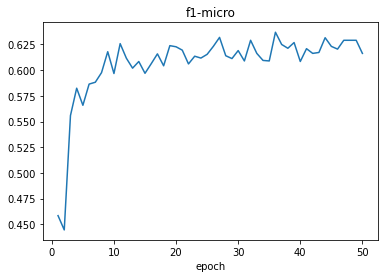

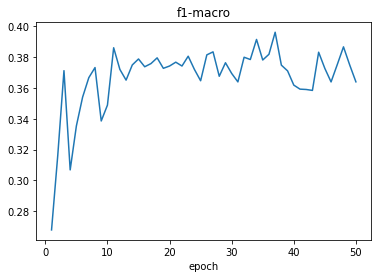

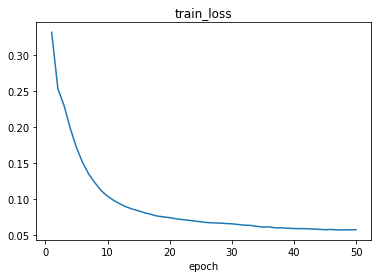

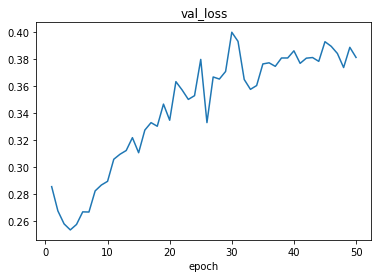

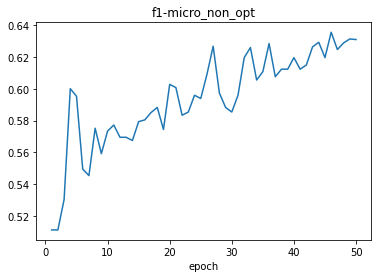

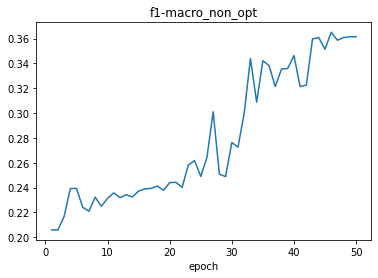

In [25]:
TRAIN = False
save_dir = "drive/MyDrive/DeepLearning/Task3/"

epochs = 50
lr = 4e-5

total_steps = len(train_dl) * epochs

optimizer = build_optimizer(model, lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

trainer = Trainer(model, optimizer, scheduler, device, loss_fn)

if TRAIN:
    trainer.train(
        train_dl, 
        dev_dl, 
        epochs, 
        dir_name="frozen-resnet-BCE-Weighted", 
        save_dir=save_dir)
    
    trainer.plot_metrics()

### TESTER

In [26]:
def add_threshold_uncertainty(thresholds, degree=2):
    """Adds uncertainty to the thresholds by flatting them towards
    0.5, following a polynomial function. The 'degree' parameter chooses
    the degree of the polynomial. If it is set to 1, the 
    thresholds are all set to 0.5 (max uncertainty)."""

    assert (int(degree) == degree and 
            degree > 0), '"degree" has to be a positive integer.'

    def uncertainty(x):
        
        u = - (x - 0.5)**degree
        if degree % 2:
            return u
        else:
            return u if x > 0.5 else -u
    
    return thresholds + np.vectorize(uncertainty)(thresholds)

x = np.arange(0, 1.1, 0.1)
y = add_threshold_uncertainty(x, degree=9)

print(x)
print(y)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.00195312 0.10026214 0.20001968 0.30000051 0.4        0.5
 0.6        0.69999949 0.79998032 0.89973786 0.99804688]


In [27]:
class Tester():
    """Evaluates a model and prints plots and metrics."""

    def __init__(self, model, dl, device, thresholds=None):

        res = eval(dl, model, device, thresholds=thresholds)

        self.outputs = res['output']
        self.pred = res['pred']
        self.true = res['true']
        self.pred_non_opt = res['pred_non_opt']

        thresholds = add_threshold_uncertainty(thresholds, degree=9)

        res = eval(dl, model, device, thresholds=thresholds)

        self.pred_uncertain = res["pred"]

    def print_f_table(self):

        f = f1_score(
            self.true, self.pred, average=None, zero_division=1)
        
        print(tabulate([f], headers=LABELS.keys(), floatfmt=".4f"))

    def print_fmacro(self):

        print("f_macro: {:10.4f}".format(f1_score(
            self.true, self.pred, average='macro', zero_division=1)))
        print("f_macro w/out threshold moving: {:10.4f}".format(f1_score(
            self.true, self.pred_non_opt, average='macro', zero_division=1)))
        print("f_macro w/ threshold uncertainty: {:10.4f}".format(f1_score(
            self.true, self.pred_uncertain, average='macro', zero_division=1)))

    def print_fmicro(self): 

        print("f_micro: {:10.4f}".format(f1_score(
            self.true, self.pred, average='micro', zero_division=1)))
        print("f_micro w/out threshold moving: {:10.4f}".format(f1_score(
            self.true, self.pred_non_opt, average='micro', zero_division=1)))
        print("f_micro w/ threshold uncertainty: {:10.4f}".format(f1_score(
            self.true, self.pred_uncertain, average='micro', zero_division=1)))
        
    def plot_confusion_matrices(self):

        cms = multilabel_confusion_matrix(self.true, self.pred)

        r = (N_LABELS // 4) + 1
        c = 4
        
        fig, axs = plt.subplots(r, c, figsize=(12, 14))
        axs = axs.flat

        titles = [
            l if len(l) < 22 else l[:20] + ".." for l in list(LABELS.keys())]

        for idx, cm in enumerate(cms):
            df_cm = pd.DataFrame(
                cm, index = ["F", "T"], columns = ["F", "T"])
            axs[idx] = sn.heatmap(
                df_cm, annot=True, ax=axs[idx], cmap=plt.cm.Greens)
            axs[idx].title.set_text(titles[idx])
            
        fig.tight_layout()
        fig.show()
        plt.show()

    def show_class_results(self, class_idx, layout='horizontal'):

        if layout != 'vertical' and layout != 'horizontal':
            print("Layout not recognized. Using horizontal.\n\
            Possible layouts: 'horizontal', 'vertical'")

        pred = [p[class_idx] for p in self.pred]
        outs = [p[class_idx] for p in self.outputs]
        true = [p[class_idx] for p in self.true]

        def colored_list(i):
            """Returns a list with true pred and out 
            at idx i colored in:
            red if true[i] == 1 and pred[i] == 0
            yellow if true[i] == 0 and pred[i] == 1
            blue otherwise"""
            c = '\033[94m'
            if true[i] - pred[i] == 1   : c = '\033[91m'
            elif true[i] - pred[i] == -1: c = '\033[93m'

            def color(n, c): return '{}{:.4f}'.format(c, n)

            return [color(true[i], c), color(pred[i], c), color(outs[i], c)]

        headers = ['y_true', 'y_pred', 'output']
        table = [ colored_list(i) for i in range(len(true)) ]

        if layout == 'vertical': 
            print(tabulate(table, headers=headers))
        else: 
            table = list(map(list, zip(*table)))
            print('\033[97moutput | ', end='')
            for o in table[2] : print(o, end='  ')
            print('\033[97m\ny_true | ', end='')
            for o in table[0] : print(o, end='  ')
            print('\033[97m\ny_pred | ', end='')
            for o in table[1] : print(o, end='  ')
            print()

    def show_all_class_results(self):

        for i in range(0, N_LABELS): 
            print("\033[97mClass {} ({}) :".format(list(LABELS.keys())[i], i))
            self.show_class_results(i)
            print()

In [28]:
def test_model(path, test_level=0, model_name=["MODEL"], use_weighted=False):

    model, thresholds = load_model(path, device, use_weighted=use_weighted)
    model.to(device)

    tester = Tester(model, test_dl, device, thresholds)

    print("####### TESTING {} #######".format(model_name.upper()))

    tester.print_fmicro()
    print()
    tester.print_fmacro()

    if test_level >= 1:
        tester.print_f_table()
        tester.plot_confusion_matrices()

    if test_level >= 2:
        tester.show_all_class_results()

    print("---------------------------")

def test_models(
    models_dir, models_names, to_test=None, test_level=0, use_weighted=False):

    err_msg = '"to_test" has to be a list of string or None'
    if to_test is not None and (not isinstance(to_test, list) or 
                                not all([isinstance(t, str) for t in to_test])):
        raise TypeError(err_msg)

    logging.set_verbosity(40)

    for model_name in models_names:
        dir = "".join([models_dir, model_name])

        f_names = []
        if to_test is None:
            for f in os.listdir(dir):
                if f.endswith(".pt"):
                    f_names.append(f)
        else:
            for m in to_test:
                f_names.append("best_model_{}.pt".format(m))

        for name in f_names:   
            path = "{}/{}".format(dir, name)
            m_name = " ".join([model_name, name[:-3]])

            test_model(path, 
                       model_name=m_name, 
                       test_level=test_level, 
                       use_weighted=use_weighted)

    logging.set_verbosity(20)

### TESTING

In [35]:
models_dir = "drive/MyDrive/DeepLearning/Task3/"
models_names = ['frozen-resnet-BCE','frozen-resnet-Focal']
to_test = ['micro', 'micro_non_opt']
test_models(models_dir, 
            models_names, 
            to_test=to_test, 
            test_level=0)

####### TESTING FROZEN-RESNET-BCE BEST_MODEL_MICRO #######
f_micro:     0.5571
f_micro w/out threshold moving:     0.5418
f_micro w/ threshold uncertainty:     0.3598

f_macro:     0.2770
f_macro w/out threshold moving:     0.2150
f_macro w/ threshold uncertainty:     0.1116
---------------------------
####### TESTING FROZEN-RESNET-BCE BEST_MODEL_MICRO_NON_OPT #######
f_micro:     0.4897
f_micro w/out threshold moving:     0.5051
f_micro w/ threshold uncertainty:     0.3241

f_macro:     0.2313
f_macro w/out threshold moving:     0.1313
f_macro w/ threshold uncertainty:     0.1061
---------------------------
####### TESTING FROZEN-RESNET-FOCAL BEST_MODEL_MICRO #######
f_micro:     0.5469
f_micro w/out threshold moving:     0.5232
f_micro w/ threshold uncertainty:     0.3672

f_macro:     0.2548
f_macro w/out threshold moving:     0.1998
f_macro w/ threshold uncertainty:     0.1023
---------------------------
####### TESTING FROZEN-RESNET-FOCAL BEST_MODEL_MICRO_NON_OPT #######
f_micro: 

In [34]:
test_models(models_dir, 
            models_names=['frozen-resnet-BCE-Weighted'], 
            to_test=to_test, 
            test_level=0,
            use_weighted=True)

####### TESTING FROZEN-RESNET-BCE-WEIGHTED BEST_MODEL_MICRO #######
f_micro:     0.5602
f_micro w/out threshold moving:     0.5155
f_micro w/ threshold uncertainty:     0.3377

f_macro:     0.2885
f_macro w/out threshold moving:     0.1396
f_macro w/ threshold uncertainty:     0.0933
---------------------------
####### TESTING FROZEN-RESNET-BCE-WEIGHTED BEST_MODEL_MICRO_NON_OPT #######
f_micro:     0.5484
f_micro w/out threshold moving:     0.5125
f_micro w/ threshold uncertainty:     0.3507

f_macro:     0.2573
f_macro w/out threshold moving:     0.1503
f_macro w/ threshold uncertainty:     0.0922
---------------------------
